In [49]:
import pandas as pd
import numpy as np


In [50]:
values_data = pd.read_csv("pivot_wide_format_data.csv")
print(len(values_data.columns))

88


First Step: PreProcess the Data
1. We want all rows to represent one observation or one instance (e.x. data for one county in one year). We also want all columns to represent one feature, which is one type of information about the observation. For this, we used pivot_wide property of pandas in the AllData.ipynb file. 
2. Non-Numeric to Numeric Conversion: Columns that were previously objects (because of "N/A" strings) are now showing as float64, which means they have been succesfully converted to numeric. THis is important for numerical analysis and understanding. 
3. Handling Missing Values: The missing values are now represented NaN (Not a Number), which will be handled appropriately by Pandas and the ML libraries
4. Data Summary using describe() to show column statistics, .dtypes() to confirm that all columns are of the correct data type, and nunique() to make sure each column's data has been succesfully read

In [51]:

values_data = pd.read_csv("pivot_wide_format_data.csv")

#Replace all NaN values with "N/A"
values_data.fillna("N/A", inplace=True)

values_data.replace("N/A", np.nan, inplace=True)

# List of column pairs to merge
column_pairs = [
    ('Child Mortality Rate (White)', 'Child Mortality Rate (white)'),
    ('Drug Overdose Mortality Rate (White)', 'Drug Overdose Mortality Rate (white)'),
    ('Firearm Fatalities Rate (White)', 'Firearm Fatalities Rate (white)'),
    ('Homicide Rate (White)', 'Homicide Rate (white)'),
    ('Infant Mortality Rate (White)', 'Infant Mortality Rate (white)'),
    ('Injury Death Rate (White)', 'Injury Death Rate (white)'),
    ('MV Mortality Rate (White)', 'MV Mortality Rate (white)'),
    ('Suicide Rate (White)', 'Suicide Rate (white)'),
    ('Teen Birth Rate (White)', 'Teen Birth Rate (white)'),
    ('YPLL Rate (White)', 'YPLL Rate (white)'),
    ('Preventable Hospitalization Rate', 'Preventable Hosp. Rate')
]

for pair in column_pairs:
    column1, column2 = pair
    # Combine the columns and prioritize the non-null values in the first column
    values_data[column1] = values_data[column1].combine_first(values_data[column2])
    # Drop the second column as its data has been merged
    values_data.drop(column2, axis=1, inplace=True)

#Convert object columns that should be numeric to float
for column in values_data.columns:
    if values_data[column].dtype == "object" and column not in ["County", "Year"]:
        values_data[column] = pd.to_numeric(values_data[column], errors="coerce")
values_data.to_csv("pivot_wide_format_data_cleaned.csv", index=False)



/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_33947/3830620394.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  values_data.fillna("N/A", inplace=True)


In [52]:
print(values_data.head())

print(values_data.dtypes)

print(values_data.describe())

print(values_data.nunique())


    County  Year  % Adults with Obesity  % Children in Poverty  \
0  Appling  2011                    NaN                   31.3   
1  Appling  2012                    NaN                   35.7   
2  Appling  2013                    NaN                   34.0   
3  Appling  2014                    NaN                   34.8   
4  Appling  2015                    NaN                   40.3   

   % Excessive Drinking  % Smokers  % Unemployed  % Uninsured  ACSC Rate  \
0                  13.2       23.0           NaN    24.600000        NaN   
1                  11.0       20.2     10.700000    23.700000        NaN   
2                   9.6       24.8     11.000000    24.900000        NaN   
3                   NaN       27.8     10.317788    25.189603        NaN   
4                   NaN       27.8     10.023661    24.231524        NaN   

   Age-Adjusted Death Rate  ...  Teen Birth Rate (Black)  \
0                      NaN  ...                      NaN   
1                      NaN

Second Step: Data Scaling
Scale the numerical data to ensure that all features contribute equally to the distance calculation in the clustering algorithm. Without scaling, features with larger ranges could influence the model more than features with smaller ranges. Scaling prevents this by ensuring that each feature has a similar influence on the model. 

For K-Means Clustering, we will be using standardization (Z-Score normalization) since K-Means is a distance-based algorithm and standardization maintains the effect of outliers in the data. In standardization, the features are rescaled so that they have properties of a standard normal distribution with a mean of 0 and standard deviation from the mean of 1. Standardization can be calculated as X - mean / (standard deviations from mean) where X represents the original value of the feature. In Pandas, we will use 'StandardScaler' from the 'sklearn.preprocessing' library

Some other data scaling techniques include min-max scaling (getting all values between given range) and robust scaling (uses the median and interquartile range or IQR so its robust to outliers)

In [53]:

from sklearn.preprocessing import StandardScaler
import pandas as pd 

#1. Seperate Features from Identifiers (County and Year). We don't want to scale identifier columns
identifiers = values_data[['County', 'Year']]
features = values_data.drop(['County', 'Year'], axis=1)

#2. Initialize Standard Scaler 
scaler = StandardScaler()

#3. Fit and transform the scaler on the features
scaled_features = scaler.fit_transform(features)

#The output of Standard Scaler is a NumPy array, so convert it back to a Data Frame 
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

#Combine the scaled features with the identifiers
data_scaled = pd.concat([identifiers, scaled_features_df], axis=1)

#Save the scaled data to a csv 
data_scaled.to_csv("pivot_wide_format_data_scaled.csv", index=False)
 

Step 3: K-Means Clustering Overview
K-Means is a centroid-based algorithm that aims to partition the dataset into k clusters in which each observation belongs to the cluster with the nearest mean. The steps typically involved in k-means clustering are (1) Initialization: choose k initial centroids (either randomly or based on some data-driven heuristic) (2) Assignment: Assign each observation to the cluster with the nearest centroid. (3) Update: Recalulcate the centroids as the mean of all observations assigned to each cluster. (4) Iteration: Repeat the assignment and update steps until the centroids do not change significantly or a maximum number of iterations is reached. 

In [54]:
#1. Apply the elbow method to determine the optimal number of clusters. The elbow method works by running the K-means 
# clustering on the dataset for a range of values (k=1 through 10), and for each value of K, you calculate the sum of 
# squared distances from each point to its assigned center. When you plot these values, the "elbow" is considered to be 
# an indicator of the appropriate number of clusters. The intuition behind the elbow method is that increasing the number
# of clusters will naturally improve the fit (explain more of the variation), since there are more parameters (cluster)
# to use, but at some point, there is overfitting, and the elbow reflects this. 

# Approach: Try each possiblity to see which gives the best values. Imputing NaN with mean. Removing
# NaN entirely. Going with DBSCAN

In [55]:
from sklearn.impute import SimpleImputer 

identifiers = values_data[['County', 'Year']]
features = values_data.drop(['County', 'Year'], axis=1)

# Calculate the percentage of NaN values in each column
nan_percentage = features.isna().mean() * 100


# Identify columns with more than a certain percentage of NaN values (e.g., more than 50%)
threshold = 30  # You can change the threshold as needed

# Drop these columns from the DataFrame
data_cleaned = features.loc[:, nan_percentage <= threshold]


#Strategy 1: Impute Missing Values with the Mean
imputer_mean = SimpleImputer(strategy='mean')

#Apply imputation to the filtered data
data_imputed_mean = pd.DataFrame(imputer_mean.fit_transform(data_cleaned), columns=data_cleaned.columns)
values_data_imputed = pd.concat([identifiers.reset_index(drop=True), data_imputed_mean.reset_index(drop=True)], axis=1)

#Strategy 2: Drop Missing Values 
data_dropped_na = data_cleaned.dropna()
values_data_dropped = pd.concat([identifiers.reset_index(drop=True), data_dropped_na.reset_index(drop=True)], axis=1)

Imputed Data


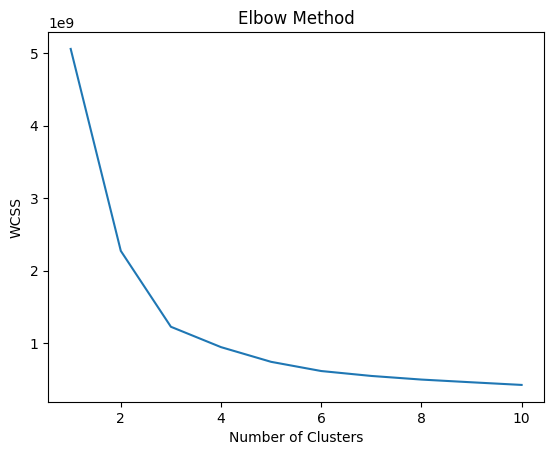

Dropped Data


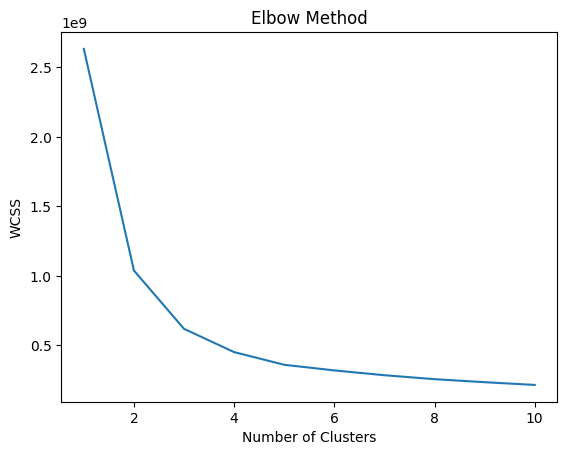

In [56]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

def apply_elbow_method(scaled_data):
    wcss = [] #Within cluster sum of squares 
    for i in range(1,11): #Trying different numbers of clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(scaled_data.drop(['County', 'Year'], axis=1)) #Fit the scaled data
        wcss.append(kmeans.inertia_) # Append the within-cluster sum of squares 

    # Plot the elbow graph 
    plt.plot(range(1,11), wcss)
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.show()

#1. Mean Imputed Data
print("Imputed Data")
apply_elbow_method(values_data_imputed)

print("Dropped Data")
values_data_dropped = values_data_dropped.dropna()
apply_elbow_method(values_data_dropped)

In [57]:
# 2. Find the point where the decrease in WCSS begins to level off, indicating that adding more clusters does not
# provide better modeling of the data In our graphs, this point is not very pronounced. We can try a couple of 
# cluster values as potential candidates for K. For more precision, you might use other methods such as 
# silhoutte coefficient to validate consistency within clusters 


The average silhoutte score is:  0.4817777441300333
    County  Year  Cluster
0  Appling  2011        0
1  Appling  2012        2
2  Appling  2013        0
3  Appling  2014        0
4  Appling  2015        0
5  Appling  2016        0
6  Appling  2017        0
7  Appling  2018        0
8  Appling  2019        0
9  Appling  2020        0


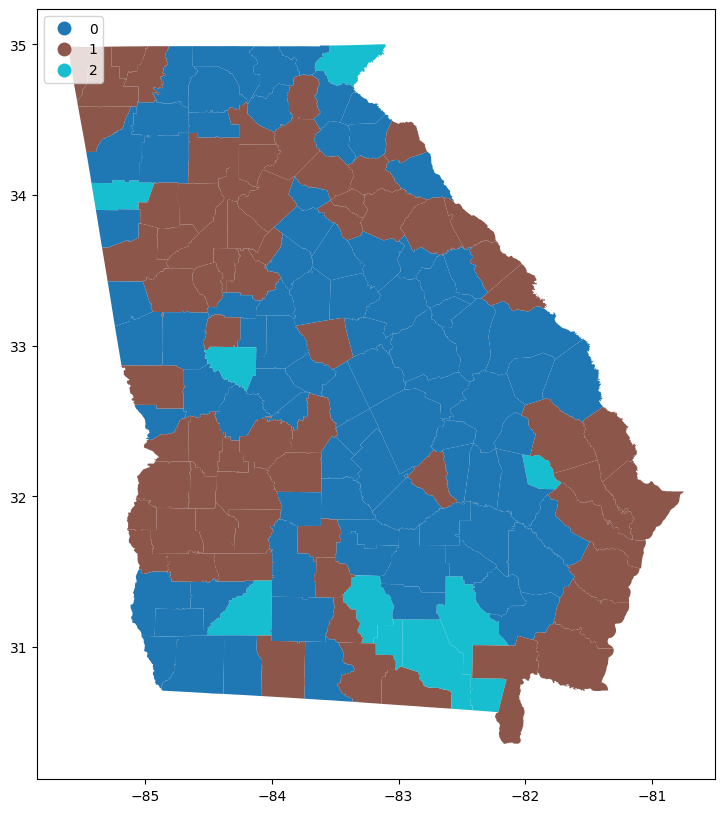

In [58]:
# Run K-Means Cluster

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import geopandas as gpd
import matplotlib.pyplot as plt

# Number of Clusters
n_clusters = 3

#Initialize the K-Means 
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=10)

# Fit the model to the scaled data (choose the correct DataFrame for your data)
cluster_labels = kmeans.fit_predict(data_imputed_mean)

#Calculate the silhoutte score
#The silhoutte score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters
# (separation). Value ranges from -1 to 1 where higher values designate that an object is well matched to its own 
# cluster and badly matched to others. 
silhoutte_avg = silhouette_score(data_imputed_mean, cluster_labels)
print("The average silhoutte score is: ",silhoutte_avg)

# Assume 'cluster_labels' is the array of cluster labels from you k-means fitting 
# Add the cluster variables to the original data frame with identifiers

values_data_imputed['Cluster'] = cluster_labels
sample_clusters = values_data_imputed[['County', 'Year', 'Cluster']].head(10) 

print(sample_clusters)


# Graph on GA Counties

#Load the shapefile for Georgia Counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')


# Filter your clustering results for the year 2022
specific_year_data = values_data_imputed[values_data_imputed['Year'] == 2022]

# Join the geographical data with the cluster data
merged_data = geo_data.set_index('NAME10').join(specific_year_data.set_index('County'))

#print(merged_data['Year'])

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='Cluster', ax=ax, legend=True, categorical=True, legend_kwds={'loc': 'upper left'})
plt.show()




The average silhoutte score is:  0.49492184080290474
    County  Year  Cluster
0  Appling  2011        1
1  Appling  2012        1
2  Appling  2013        1
3  Appling  2014        1
4  Appling  2015        0
5  Appling  2016        1
6  Appling  2017        1
7  Appling  2018        1
8  Appling  2019        0
9  Appling  2020        0


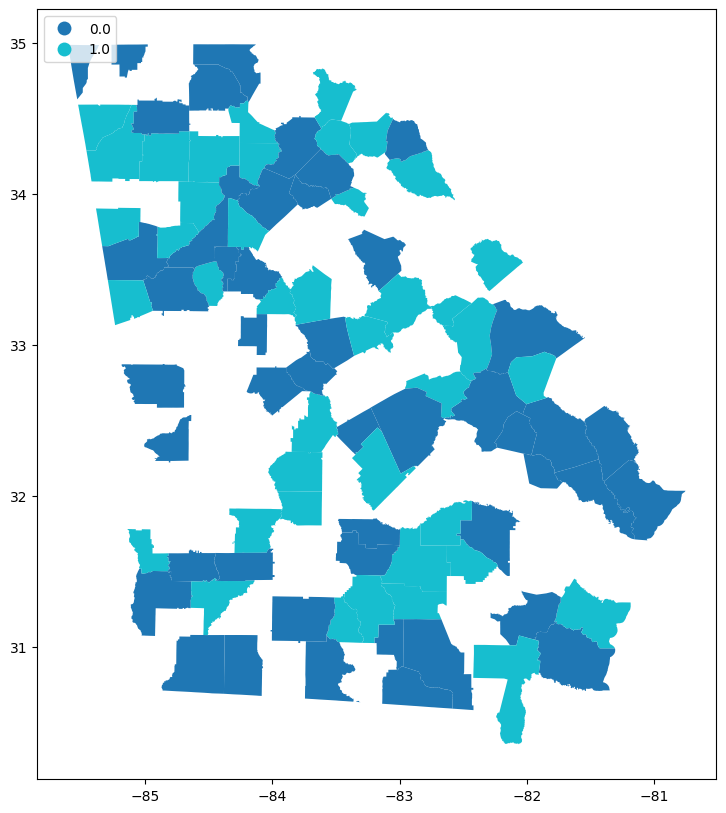

In [59]:
# Run K-Means Cluster

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import geopandas as gpd
import matplotlib.pyplot as plt

# Number of Clusters
n_clusters = 2

#Initialize the K-Means 
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=10)

# Fit the model to the scaled data (choose the correct DataFrame for your data)
cluster_labels = kmeans.fit_predict(data_dropped_na)

#Calculate the silhoutte score
silhoutte_avg = silhouette_score(data_dropped_na, cluster_labels)
print("The average silhoutte score is: ",silhoutte_avg)

values_data_dropped['Cluster'] = cluster_labels



sample_clusters = values_data_dropped[['County', 'Year', 'Cluster']].head(10) 
print(sample_clusters)

# Graph on GA Counties

#Load the shapefile for Georgia Counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')


# Filter your clustering results for the year 2022
specific_year_data = values_data_dropped[values_data_dropped['Year'] == 2022]

# Join the geographical data with the cluster data
merged_data = geo_data.set_index('NAME10').join(specific_year_data.set_index('County'))

#print(merged_data['Year'])

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='Cluster', ax=ax, legend=True, categorical=True, legend_kwds={'loc': 'upper left'})
plt.show()



Step 4: Creating GA Counties Map Showing Cluster Membership

In [60]:
# 1. Test with different NaN Threshold values and Clusters to determine optimal threshold, cluster pair 

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt


def find_optimal_clusters(data, max_clusters):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    best_num_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
    return best_num_clusters, max(silhouette_scores)

def plot_silhouette(centerMeasure):
    threshold_values = range(0, 101, 10)
    optimal_params = []

    thresholds = []
    best_sillhouette_scores = []

    # For each threshold value
    for try_threshold in threshold_values:
        
        features = values_data.drop(['County', 'Year'], axis=1)

        # Calculate the percentage of NaN values in each column
        nan_percentage = features.isna().mean() * 100

        # Identify columns with more than a certain percentage of NaN values (e.g., more than 50%)
        threshold = try_threshold  

        # Keep only the columns that have nan_percentage <= threshold 
        data_cleaned = features.loc[:, nan_percentage <= threshold]

        data_imputed = None
        if centerMeasure == "mean":
            #Strategy 1: Impute Missing Values with the Mean
            imputer_mean = SimpleImputer(strategy='mean')

            #Apply imputation to the filtered data
            data_imputed = pd.DataFrame(imputer_mean.fit_transform(data_cleaned), columns=data_cleaned.columns)
        elif centerMeasure == "median":
            #Strategy 2: Impute Missing Values with the Median
            imputer_median = SimpleImputer(strategy='median')

            #Apply imputation to the filtered data
            data_imputed = pd.DataFrame(imputer_median.fit_transform(data_cleaned), columns=data_cleaned.columns)
        # Find the optimal number of clusters for this threshold
        best_clusters, best_score = find_optimal_clusters(data_imputed, 10)
        
        # Append to thresholds and best_sillhouette_scores to create the graphs 
        thresholds.append(try_threshold)
        best_sillhouette_scores.append(best_score)
        
        # Store the best number of clusters and silhouette score for this threshold
        optimal_params.append((threshold, best_clusters, best_score))
        

    # Now find the overall best parameters
    overall_best = max(optimal_params, key=lambda x: x[2])

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, best_sillhouette_scores, marker='o')
    plt.title("Silhoutte Score for Different NaN Threshold Values Given Optimal Number of Clusters")
    plt.xlabel("NaN Threshold (%)")
    plt.ylabel("Best Silhouette Score")
    plt.xticks(threshold_values)
    plt.grid(True)
    plt.show()

    print(f"Best parameters: Threshold = {overall_best[0]}, Number of Clusters = {overall_best[1]}, Silhouette Score = {overall_best[2]}")


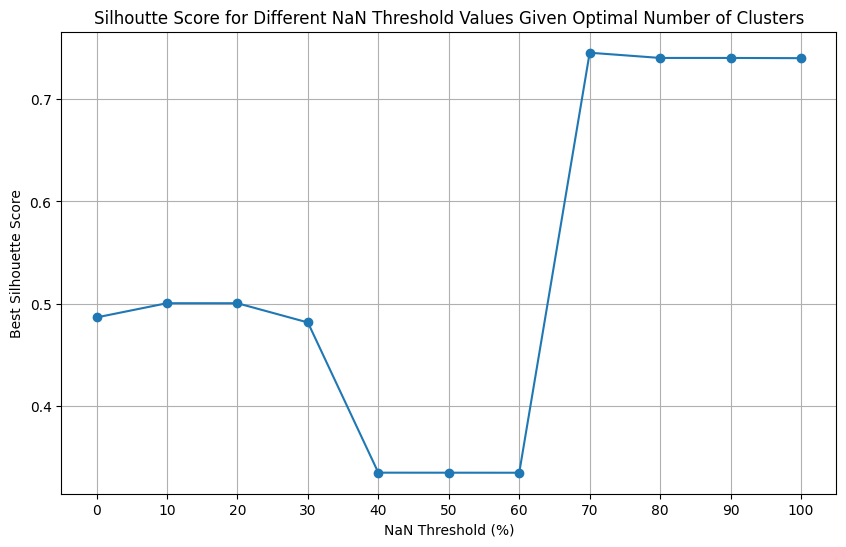

Best parameters: Threshold = 70, Number of Clusters = 2, Silhouette Score = 0.7454025069334484


In [62]:
plot_silhouette("mean")

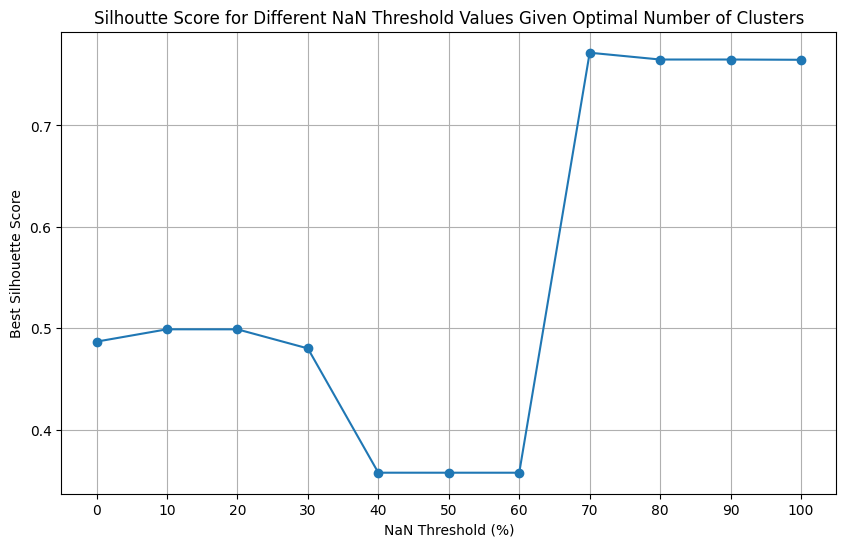

Best parameters: Threshold = 70, Number of Clusters = 2, Silhouette Score = 0.7717209034056084


In [63]:
plot_silhouette("median")

Beginning Feature Importance Research
- Random Forest: Supervised 
- PCA: Unsupervised (Goal is to determine a new set of limited features (principal components) that take into account all the original features and finds a way to group together similar ones/ones that are strongly correlated to reduce the dimensionality of the data. We want to reduce the dimensionality of the data because data that has more than 2 or 3 diemsnsions is extremely hard to visualize). The technique aims to preserve as much of the significant structure of the high-dimensional data as possible in the lower-dimensional representation, making it possible to visualize and interpret the data. 

In [64]:
from sklearn.impute import SimpleImputer 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

identifiers = values_data[['County', 'Year']]
features = values_data.drop(['County', 'Year'], axis=1)

# Calculate the percentage of NaN values in each column
nan_percentage = features.isna().mean() * 100



# Identify columns with more than a certain percentage of NaN values (e.g., more than 50%)
threshold = 20  # You can change the threshold as needed

#print(len(features.columns[nan_percentage <= threshold]))
#print(features.columns[nan_percentage <= threshold])

#Only keep the columns that have NaN percentages less than threshold
data_cleaned = features.loc[:, nan_percentage <= threshold]
columns_to_delete = features.columns[nan_percentage > threshold]
#print(columns_to_delete)
print(len(features.columns))
print(len(columns_to_delete))


#Strategy 1: Impute Missing Values with the Mean
imputer_median = SimpleImputer(strategy='median')

#Apply imputation to the filtered data
data_imputed_median = pd.DataFrame(imputer_median.fit_transform(data_cleaned), columns=data_cleaned.columns)
values_data_imputed = pd.concat([identifiers.reset_index(drop=True), data_imputed_median.reset_index(drop=True)], axis=1)



kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(values_data_imputed.drop(['County', 'Year'], axis=1)) 


# All the columns being deleted: 
#Index(['ACSC Rate', 'Age-Adjusted Death Rate', 'Age-adjusted Death Rate',
    #    'Child Mortality Rate (Asian)', 'Child Mortality Rate (Black)',
    #    'Child Mortality Rate (Hispanic)', 'Child Mortality Rate (White)',
    #    'Drug Overdose Mortality Rate', 'Drug Overdose Mortality Rate (Asian)',
    #    'Drug Overdose Mortality Rate (Black)',
    #    'Drug Overdose Mortality Rate (Hispanic)',
    #    'Drug Overdose Mortality Rate (White)',
    #    'Firearm Fatalities Rate (Asian)', 'Firearm Fatalities Rate (Black)',
    #    'Firearm Fatalities Rate (Hispanic)', 'Firearm Fatalities Rate (White)',
    #    'Homicide Rate (Asian)', 'Homicide Rate (Black)',
    #    'Homicide Rate (Hispanic)', 'Homicide Rate (White)',
    #    'Infant Mortality Rate', 'Infant Mortality Rate (Asian)',
    #    'Infant Mortality Rate (Black)', 'Infant Mortality Rate (Hispanic)',
    #    'Infant Mortality Rate (White)', 'Injury Death Rate (Asian)',
    #    'Injury Death Rate (Black)', 'Injury Death Rate (Hispanic)',
    #    'Injury Death Rate (White)', 'MV Mortality Rate (Asian)',
    #    'MV Mortality Rate (Black)', 'MV Mortality Rate (Hispanic)',
    #    'MV Mortality Rate (White)', 'Mammography Rate',
    #    'Motor Vehicle Mortality Rate', 'Suicide Rate (Age-Adjusted)',
    #    'Suicide Rate (Asian)', 'Suicide Rate (Black)',
    #    'Suicide Rate (Hispanic)', 'Suicide Rate (White)',
    #    'Teen Birth Rate (Asian)', 'Teen Birth Rate (Black)',
    #    'Teen Birth Rate (Hispanic)', 'Teen Birth Rate (White)',
    #    'YPLL Rate (Asian)', 'YPLL Rate (Black)', 'YPLL Rate (Hispanic)',
    #    'YPLL Rate (White)'],
    #   dtype='object')




75
67


KMeans(n_clusters=2, n_init=10, random_state=0)

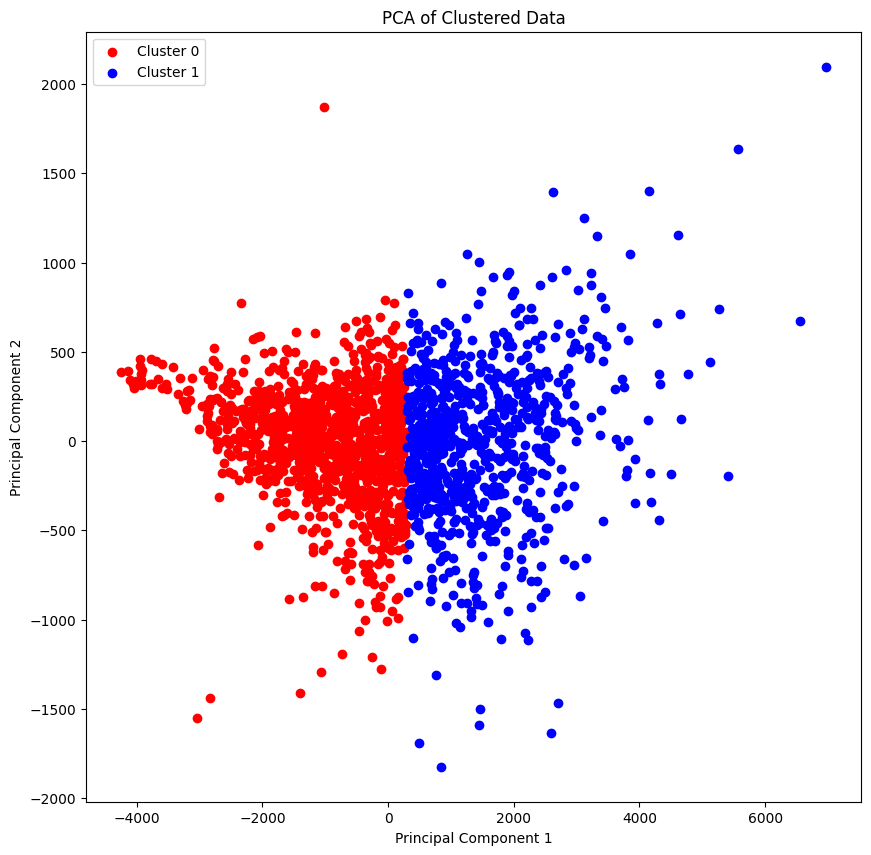

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import numpy as np

# Centroid Analysis

#Extract the centroids of the different clusters - Each centroid is the mean position of all the points in the cluster. 
# Since I have 2 clusters, it will be an array of 2 elements, each representing the center of a cluster 
centroids = kmeans.cluster_centers_

#Analyze the centroids

# Apply PCA - Reduces the dataset to 2 dimensions to make it easier to analyze 
pca = PCA(n_components=2)
principle_components = pca.fit_transform(data_imputed_median)

#Plot the PCA-reduced data - Visualizes the data in the new coordinate system with the principle components being the 
# only dimensions 
plt.figure(figsize=(10, 10))
colors = ['red', 'blue']
for color, i in zip (colors, range(len(centroids))):
    plt.scatter(principle_components[kmeans.labels_ == i, 0], 
                principle_components[kmeans.labels_ == i, 1], 
                color = color, 
                label=f'Cluster {i}')
plt.title("PCA of Clustered Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()



In [66]:
print("Number of features:", len(data_imputed_median.columns))
print("Length of centroids:", centroids.shape)

Number of features: 8
Length of centroids: (2, 8)


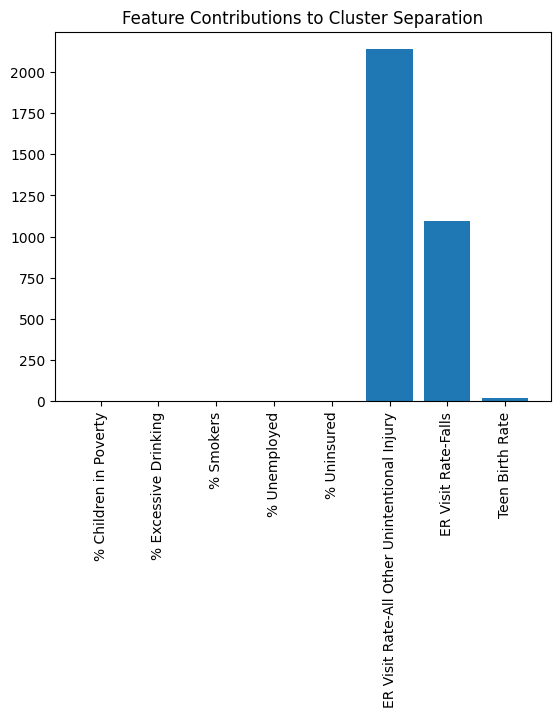

In [67]:
# Feature contribution (difference between centroids)

#Computes the absolute difference between the feature values of the 2 centroids for each feature. In other words, 
# we're comparing the average (mean) values of each feature across the clusters. 
centroid_diff = np.abs(centroids[0] - centroids[1])  # Example for 2 clusters
features = data_imputed_median.columns
plt.bar(range(len(features)), centroid_diff)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title("Feature Contributions to Cluster Separation")
plt.show()

BACKTRACK: We have realized that we are introducing a lot of bias/potential error in the machine learning model we have built by imputing over 70% of data values using median or mode. 

Next Step: Backtrack back to the data acquisition stage and determine a better way to impute the missing values

Chosen Approach: Time Series Regression Model 



In [68]:
import pandas as pd 

cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")

# Threshold Columns Table
identifiers = cleaned_data_table[['County', 'Year']]
features = cleaned_data_table.drop(['County', 'Year'], axis=1)

# Calculate the percentage of NaN values in each column
nan_percentage = features.isna().mean() * 100

# Identify columns with more than a certain percentage of NaN values (e.g., more than 50%)
threshold_values = range(0, 101, 10)
num_removed = []
num_left = []
total_columns = len(features.columns)
for threshold in threshold_values:
    num_removing = len(features.columns[nan_percentage > threshold])
    num_removed.append(num_removing)
    num_deleting = len(features.columns) - num_removing
    num_left.append(num_deleting)


# Creating a DataFrame to display the table 
threshold_table = pd.DataFrame({
    'Threshold (%)': threshold_values,
    'Total Columns': [total_columns] * len(threshold_values),
    'Columns Removed': num_removed,
    'Columns Left': num_left
})

print(threshold_table)

print(features.columns[nan_percentage <= 30])

    Threshold (%)  Total Columns  Columns Removed  Columns Left
0               0             75               73             2
1              10             75               69             6
2              20             75               67             8
3              30             75               65            10
4              40             75               63            12
5              50             75               59            16
6              60             75               54            21
7              70             75               48            27
8              80             75               36            39
9              90             75               32            43
10            100             75                0            75
Index(['% Children in Poverty', '% Excessive Drinking', '% Smokers',
       '% Unemployed', '% Uninsured',
       'ER Visit Rate-All Other Unintentional Injury', 'ER Visit Rate-Falls',
       'Injury Death Rate', 'Teen Birth Rate', 

In [69]:
filtered_data_table_50 = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.5].copy()
filtered_data_table_30 = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()

print(filtered_data_table_50.columns)
print(filtered_data_table_30.columns)



Index(['County', 'Year', '% Children in Poverty', '% Excessive Drinking',
       '% Smokers', '% Unemployed', '% Uninsured',
       'Age-Adjusted Death Rate-Drug Overdoses', 'Death Rate-Drug Overdoses',
       'ER Visit Rate-All Other Unintentional Injury', 'ER Visit Rate-Falls',
       'Injury Death Rate', 'MV Mortality Rate',
       'Percent of Deaths by Cause-All Opioids',
       'Preventable Hospitalization Rate', 'Teen Birth Rate',
       'Violent Crime Rate', 'Years of Potential Life Lost Rate'],
      dtype='object')
Index(['County', 'Year', '% Children in Poverty', '% Excessive Drinking',
       '% Smokers', '% Unemployed', '% Uninsured',
       'ER Visit Rate-All Other Unintentional Injury', 'ER Visit Rate-Falls',
       'Injury Death Rate', 'Teen Birth Rate', 'Violent Crime Rate'],
      dtype='object')


In [70]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# Chosen threshold value: 30%
filtered_data_table = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()

# Impute missing values for ALL features using the best (linear vs quadratic) time-series model
# and extract coefficients for feature engineering.
def impute_with_time_series_models(data_table):
    data_table = data_table.copy()
    data_table['Year'] = pd.to_numeric(data_table['Year'])

    coefficients_list = []
    features = data_table.columns.drop(['County', 'Year'])

    for feature_name in features:
        for county in data_table['County'].unique():
            county_mask = data_table['County'] == county
            county_data = data_table.loc[county_mask, ['Year', feature_name]].dropna()

            # Need at least 3 observations to fit a trend model
            if len(county_data) < 3:
                continue

            X = county_data['Year'].values.reshape(-1, 1)
            y = county_data[feature_name].values

            # Linear model: y = b*x + c
            linear_model = LinearRegression()
            linear_model.fit(X, y)
            r2_linear = r2_score(y, linear_model.predict(X))

            # Quadratic model: y = a*x^2 + b*x + c
            poly = PolynomialFeatures(degree=2, include_bias=False)
            X_poly = poly.fit_transform(X)
            quadratic_model = LinearRegression()
            quadratic_model.fit(X_poly, y)
            r2_quadratic = r2_score(y, quadratic_model.predict(X_poly))

            use_linear = r2_linear >= r2_quadratic

            if use_linear:
                coef_a = 0.0
                coef_b = float(linear_model.coef_[0])
                coef_c = float(linear_model.intercept_)
            else:
                # X_poly columns are [x, x^2]
                coef_a = float(quadratic_model.coef_[1])
                coef_b = float(quadratic_model.coef_[0])
                coef_c = float(quadratic_model.intercept_)

            # Save coefficients for feature engineering
            coefficients_list.extend([
                {'County': county, 'Feature': feature_name, 'Coefficient': 'a', 'Value': coef_a},
                {'County': county, 'Feature': feature_name, 'Coefficient': 'b', 'Value': coef_b},
                {'County': county, 'Feature': feature_name, 'Coefficient': 'c', 'Value': coef_c},
            ])

            # Impute missing values for this county-feature using the chosen model
            missing_mask = county_mask & data_table[feature_name].isna()
            if missing_mask.any():
                X_missing = data_table.loc[missing_mask, 'Year'].values.reshape(-1, 1)
                if use_linear:
                    preds = linear_model.predict(X_missing)
                else:
                    X_missing_poly = poly.transform(X_missing)
                    preds = quadratic_model.predict(X_missing_poly)
                data_table.loc[missing_mask, feature_name] = preds

    coefficients_df = pd.DataFrame(coefficients_list)
    return data_table, coefficients_df


imputed_data_table, coefficients_df = impute_with_time_series_models(filtered_data_table)

# Save outputs for downstream steps
imputed_data_table.to_csv('pivot_wide_format_data_imputed_timeseries.csv', index=False)
coefficients_df.to_csv('model_coefficients_for_all_features.csv', index=False)

# Optional diagnostic: linear R^2 for a single feature (example)
def compute_r2_scores(data_table, feature_name):
    r2_scores = {}
    for county in data_table['County'].unique():
        county_data = data_table[data_table['County'] == county].dropna(subset=[feature_name])
        if len(county_data) < 3:
            continue
        X = county_data['Year'].values.reshape(-1, 1)
        y = county_data[feature_name].values
        model = LinearRegression()
        model.fit(X, y)
        r2_scores[county] = r2_score(y, model.predict(X))
    return r2_scores

r2_scores = compute_r2_scores(filtered_data_table, 'Teen Birth Rate')

r2_df = pd.DataFrame(list(r2_scores.items()),
                     columns=['County', 'R2']).sort_values(by='R2', ascending=False)

print(r2_df)

# Select top N counties
top_counties = r2_df.head(3)['County'].tolist()
top_counties_R2 = r2_df.head(3)['R2'].tolist()

print(top_counties)
print(top_counties_R2)

# Select bottom N counties
worst_counties = r2_df.tail(3)['County'].tolist()
worst_counties_R2 = r2_df.tail(3)['R2'].tolist()

print(worst_counties)
print(worst_counties_R2)



            County        R2
125       Spalding  0.987823
156         Wilkes  0.985641
21         Carroll  0.985613
47         Douglas  0.984409
64           Grady  0.984382
..             ...       ...
61        Glascock  0.624717
3            Baker  0.590226
25   Chattahoochee  0.582863
130     Taliaferro  0.326309
12        Brantley  0.003680

[159 rows x 2 columns]
['Spalding', 'Wilkes', 'Carroll']
[0.9878232700899118, 0.9856411818388643, 0.9856130056492786]
['Chattahoochee', 'Taliaferro', 'Brantley']
[0.5828630046101454, 0.32630875003616155, 0.003679872266469042]


In [71]:
print(filtered_data_table['Teen Birth Rate'].isna().mean())

0.0009675858732462506


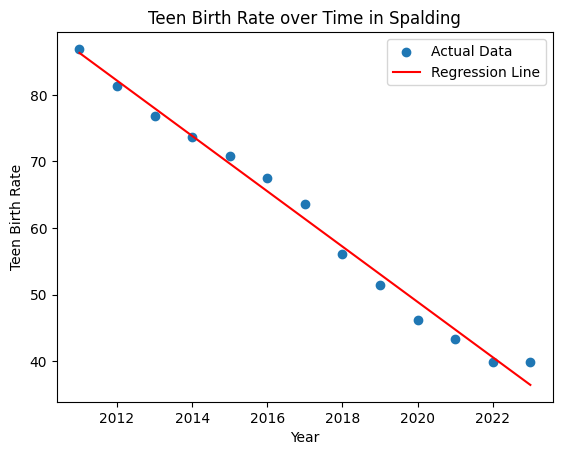

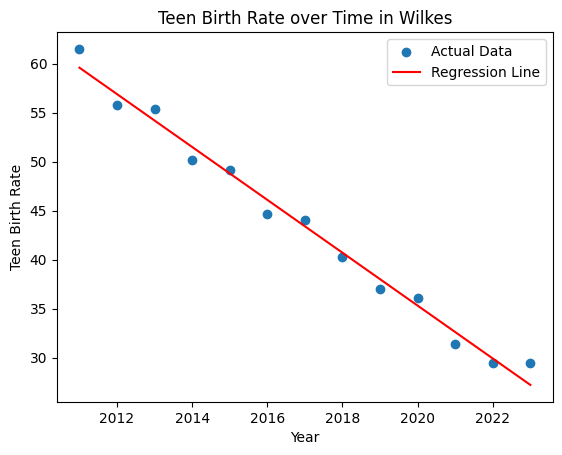

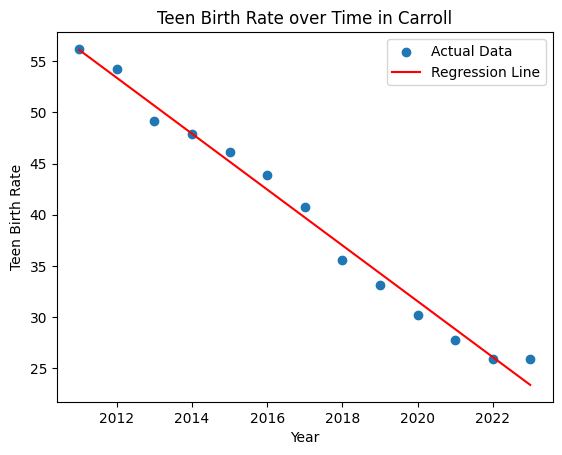

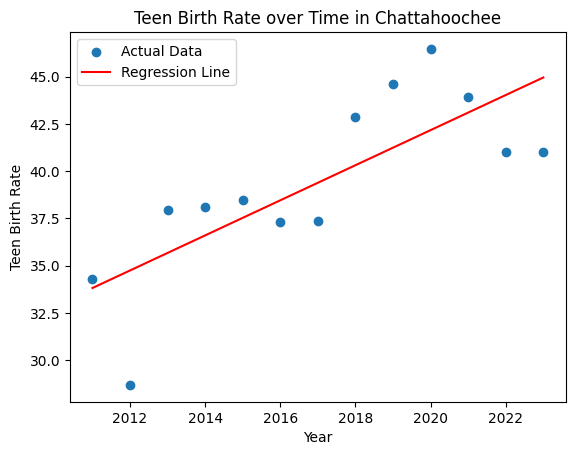

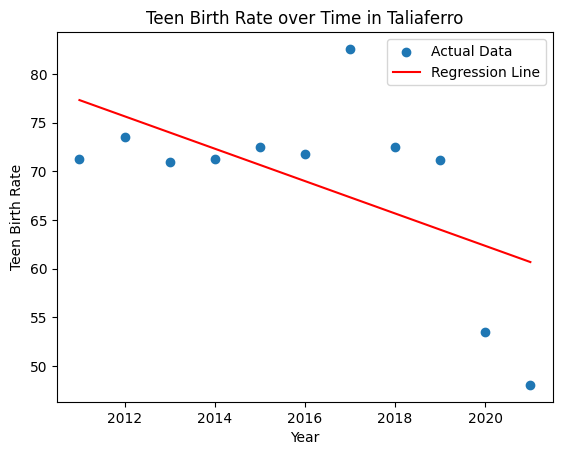

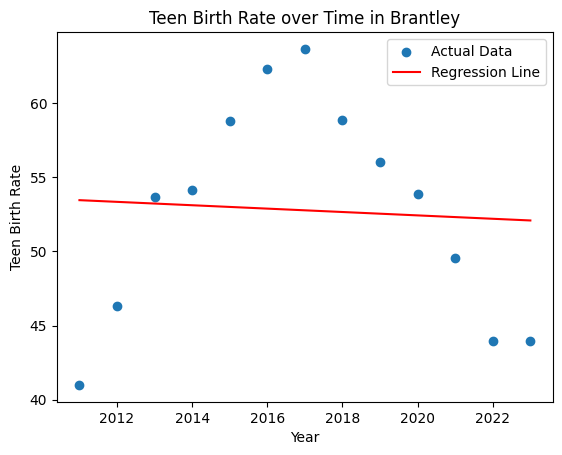

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_county_regression(data_table, feature_name, county_name):
    county_data_table = data_table[data_table['County'] == county_name]

    # Drop rows where the feature is missing so the model can fit
    county_data_table = county_data_table.dropna(subset=[feature_name])
    if county_data_table.empty:
        return

    plt.scatter(county_data_table['Year'], county_data_table[feature_name], label="Actual Data")

    # Fit and Plot the Linear Regression Model
    X = county_data_table['Year'].values.reshape(-1, 1)
    Y = county_data_table[feature_name]
    model = LinearRegression()
    model.fit(X, Y)
    plt.plot(county_data_table['Year'], model.predict(X), color='red', label="Regression Line")

    plt.title(f"{feature_name} over Time in {county_name}")
    plt.xlabel("Year")
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()
    
# Visualize for counties with highest R^2
for county in top_counties:
    plot_county_regression(filtered_data_table, 'Teen Birth Rate', county)
    
# Visualize for counties with lowest R^2
for county in worst_counties:
    plot_county_regression(filtered_data_table, 'Teen Birth Rate', county)
    

Step 2: Decision WorkFlow - Liner and Quadratic Fit Model Imputation 
- For models that are not fit well with a linear model, try a quadratic fit 

In [73]:
import pandas as pd

# Reload coefficients if running this cell independently
coefficients_df = pd.read_csv('model_coefficients_for_all_features.csv')


In [74]:
# Creating a pivot-wide version of the above dataset and standardizing it

import pandas as pd
from sklearn.preprocessing import StandardScaler


# Assuming 'coefficients_df' is your DataFrame loaded with the coefficients data

# Pivot the DataFrame
pivoted_df = coefficients_df.pivot_table(index='County',
                                         columns=['Feature', 'Coefficient'],
                                         values='Value').reset_index()

# Reset the index to make 'County' a column again if needed
pivoted_df.reset_index(inplace=True)

# Flatten the columns
pivoted_df.columns = ['_'.join(col).strip() for col in pivoted_df.columns.values]

# If you ended up with a leading underscore for 'County' column, you can rename it
pivoted_df.rename(columns={'County_': 'County'}, inplace=True)

# Replace unwanted characters in column names
pivoted_df.columns = pivoted_df.columns.str.replace(' ', '_').str.replace('%', 'Pct')
pivoted_df = pivoted_df.drop(columns=['index_'])

scaler = StandardScaler()

# Select only the columns we want to standardize (i.e., exclude 'County')
features_to_scale = pivoted_df.columns.drop('County')

# Apply the scaler to each feature column separately and update the DataFrame
for feature in features_to_scale:
    pivoted_df[feature] = scaler.fit_transform(pivoted_df[feature].values.reshape(-1, 1))


pivoted_df.to_csv('pivoted_model_coefficients_for_all_features.csv', index=False)

# --- Optional: regenerate 50% threshold coefficients using the same method ---
# This keeps your 50% sensitivity visuals aligned with the new imputation approach.
filtered_data_table_50 = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.5].copy()

imputed_data_table_50, coefficients_df_50 = impute_with_time_series_models(filtered_data_table_50)

coefficients_df_50.to_csv('Threshold_DBs/50_model_coefficients_for_all_features.csv', index=False)

pivoted_df_50 = coefficients_df_50.pivot_table(index='County',
                                               columns=['Feature', 'Coefficient'],
                                               values='Value').reset_index()

pivoted_df_50.reset_index(inplace=True)

pivoted_df_50.columns = ['_'.join(col).strip() for col in pivoted_df_50.columns.values]

pivoted_df_50.rename(columns={'County_': 'County'}, inplace=True)

pivoted_df_50.columns = pivoted_df_50.columns.str.replace(' ', '_').str.replace('%', 'Pct')
pivoted_df_50 = pivoted_df_50.drop(columns=['index_'])

scaler_50 = StandardScaler()
features_to_scale_50 = pivoted_df_50.columns.drop('County')
for feature in features_to_scale_50:
    pivoted_df_50[feature] = scaler_50.fit_transform(pivoted_df_50[feature].values.reshape(-1, 1))

pivoted_df_50.to_csv('Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv', index=False)



In [75]:
print(len(pivoted_df.columns))

31


In [76]:
print(pivoted_df.isna().sum())


County                                            0
Pct_Children_in_Poverty_a                         0
Pct_Children_in_Poverty_b                         0
Pct_Children_in_Poverty_c                         0
Pct_Excessive_Drinking_a                          0
Pct_Excessive_Drinking_b                          0
Pct_Excessive_Drinking_c                          0
Pct_Smokers_a                                     0
Pct_Smokers_b                                     0
Pct_Smokers_c                                     0
Pct_Unemployed_a                                  0
Pct_Unemployed_b                                  0
Pct_Unemployed_c                                  0
Pct_Uninsured_a                                   0
Pct_Uninsured_b                                   0
Pct_Uninsured_c                                   0
ER_Visit_Rate-All_Other_Unintentional_Injury_a    2
ER_Visit_Rate-All_Other_Unintentional_Injury_b    2
ER_Visit_Rate-All_Other_Unintentional_Injury_c    2
ER_Visit_Rat

In [77]:
print(filtered_data_table['Teen Birth Rate'].isna().mean())

0.0009675858732462506
